In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# dev train loop + model for respeller

# command line args

In [155]:
# imitate CLAs
import sys
sys.argv = [
    'train.py',
    '--fastpitch-chkpt', 'fastpitch/exps/test_addspaces_1_eos_dollar/FastPitch_checkpoint_50.pt',
    '--input-type', 'char',
    '--symbol-set', 'english_basic_lowercase',
    '--use-mas',
    '--cuda',
    '--n-speakers', '1',
    '--use-sepconv',
    '--add-spaces',
    '--eos-symbol', '$',
]

# Imports

In [156]:
'''
Train respeller model

We backpropagate loss from pretrained TTS model to a Grapheme-to-Grapheme (G2G) respeller model to help it respell words
into a simpler form

Intermediated respellings are discrete character sequences
We can backpropagate through these using gumbel softmax and the straight through estimator
'''
import argparse
import numpy as np
import torch
import torch.distributed as dist
import torch.nn.functional as F

from fastpitch import models as fastpitch_model
from fastpitch.common.text.text_processing import TextProcessor

from modules.model import EncoderRespeller
from modules.gumbel_vector_quantizer import GumbelVectorQuantizer
from modules.sdtw_cuda_loss import SoftDTW

import librosa
import librosa.display
import matplotlib.pyplot as plt

# Functions

In [225]:
def parse_args(parser):
    """Parse commandline arguments"""
    # parser.add_argument('-o', '--output', type=str, required=True,
    #                     help='Directory to save checkpoints')
    parser.add_argument('-d', '--dataset-path', type=str, default='./',
                        help='Path to dataset')

    train_args = parser.add_argument_group('training setup')
    train_args.add_argument('--cuda', action='store_true',
                      help='Enable GPU training')
    train_args.add_argument('--batch-size', type=int, default=16,
                      help='Batchsize (this is divided by number of GPUs if running Data Distributed Parallel Training)')
    train_args.add_argument('--seed', type=int, default=1337,
                       help='Seed for PyTorch random number generators')
    train_args.add_argument('--grad-accumulation', type=int, default=1,
                       help='Training steps to accumulate gradients for')
    train_args.add_argument('--epochs', type=int, default=100, #required=True,
                       help='Number of total epochs to run')
    train_args.add_argument('--epochs-per-checkpoint', type=int, default=10,
                       help='Number of epochs per checkpoint')

    data_args = parser.add_argument_group('dataset parameters')
    cond_args = parser.add_argument_group('conditioning on additional attributes')
    audio_args = parser.add_argument_group('log generated audio')
    dist_args = parser.add_argument_group('distributed training setup')

    arch_args = parser.add_argument_group('architecture')
    arch_args.add_argument('--d-model', type=int, default=512,
                       help='Hidden dimension of tranformer')
    arch_args.add_argument('--latent-temp', type=tuple, default=(2, 0.5, 0.999995),
                       help='Temperature annealling parameters for Gumbel-Softmax (start, end, decay)')

    pretrained_tts_args = parser.add_argument_group('pretrained tts model')
    # pretrained_tts_args.add_argument('--fastpitch-with-mas', type=bool, default=True,
    #                   help='Whether or not fastpitch was trained with Monotonic Alignment Search (MAS)')
    pretrained_tts_args.add_argument('--fastpitch-chkpt', type=str, required=True,
                      help='Path to pretrained fastpitch checkpoint')
    pretrained_tts_args.add_argument('--input-type', type=str, default='char',
                      choices=['char', 'phone', 'pf', 'unit'],
                      help='Input symbols used, either char (text), phone, pf '
                      '(phonological feature vectors) or unit (quantized acoustic '
                      'representation IDs)')
    pretrained_tts_args.add_argument('--symbol-set', type=str, default='english_basic_lowercase',
                      help='Define symbol set for input sequences. For quantized '
                      'unit inputs, pass the size of the vocabulary.')
    pretrained_tts_args.add_argument('--n-speakers', type=int, default=1,
                      help='Condition on speaker, value > 1 enables trainable '
                      'speaker embeddings.')
    # pretrained_tts_args.add_argument('--use-sepconv', type=bool, default=True,
    #                   help='Use depthwise separable convolutions')

    return parser

def load_checkpoint(args, model, filepath):
    if args.local_rank == 0:
        print(f'Loading model and optimizer state from {filepath}')
    checkpoint = torch.load(filepath, map_location='cpu')
    sd = {k.replace('module.', ''): v
          for k, v in checkpoint['state_dict'].items()}
    getattr(model, 'module', model).load_state_dict(sd)
    return model

def freeze_weights(model):
    # NB wait... won't this stop backprop of gradients?
    # We just don't want to add the fastpitch/quantiser model weights to the optimiser...
    for param in model.parameters():
        param.requires_grad = False

def init_embedding_weights(source_tensor, target_tensor):
    """copy weights inplace from source tensor to target tensor"""
    target_tensor.requires_grad = False
    target_tensor.copy_(source_tensor.clone().detach())
    target_tensor.requires_grad = True

def load_pretrained_fastpitch(args):
    # load chkpt
    device = torch.device('cuda' if args.cuda else 'cpu')
    model_config = fastpitch_model.get_model_config('FastPitch', args)
    fastpitch = fastpitch_model.get_model('FastPitch', model_config, device, forward_is_infer=True)
    load_checkpoint(args, fastpitch, args.fastpitch_chkpt)
    # get information about grapheme embedding table
    n_symbols = fastpitch.encoder.word_emb.weight.size(0)
    grapheme_embedding_dim = fastpitch.encoder.word_emb.weight.size(1)
    return fastpitch, n_symbols, grapheme_embedding_dim

# main()

In [226]:
parser = argparse.ArgumentParser(description='PyTorch Respeller Training', allow_abbrev=False)
parser = parse_args(parser)
args, _unk_args = parser.parse_known_args()

parser = fastpitch_model.parse_model_args('FastPitch', parser)
args, unk_args = parser.parse_known_args()
if len(unk_args) > 0:
    raise ValueError(f'Invalid options {unk_args}')

if args.cuda:
    args.num_gpus = torch.cuda.device_count()
    args.distributed_run = args.num_gpus > 1
    args.batch_size = int(args.batch_size / args.num_gpus)
else:
    args.distributed_run = False

torch.manual_seed(args.seed)
np.random.seed(args.seed)

if args.distributed_run:
    mp.spawn(train, nprocs=args.num_gpus, args=(args,))

# train()

In [227]:
rank = 0
device = 'cuda'

args.local_rank = rank
tts, n_symbols, grapheme_embedding_dim = load_pretrained_fastpitch(args)
tts.to(device)

respeller = EncoderRespeller(n_symbols=n_symbols, d_model=args.d_model)
respeller.to(device)

quantiser = GumbelVectorQuantizer(
    in_dim=args.d_model,
    codebook_size=n_symbols,  # number of codebook entries
    embedding_dim=grapheme_embedding_dim,
    temp=args.latent_temp,
)
quantiser.to(device)

init_embedding_weights(tts.encoder.word_emb.weight.unsqueeze(0), quantiser.vars)

# batch_size, len_x, len_y, dims = 8, 15, 12, 5
# x = torch.rand((batch_size, len_x, dims), requires_grad=True)
# y = torch.rand((batch_size, len_y, dims))

# acoustic_loss_fn = SoftDTW(use_cuda=True, gamma=0.1, dist_func=F.mse_loss)
acoustic_loss_fn = SoftDTW(use_cuda=True, gamma=0.1)
# input should be size [bsz, seqlen, dim]
acoustic_loss_fn.to(device)

Loading model and optimizer state from fastpitch/exps/test_addspaces_1_eos_dollar/FastPitch_checkpoint_50.pt


SoftDTW()

In [228]:
# skip_emb(fastpitch)

# if args.respeller_loss:
#     respelling_loss_fn = CrossEntropy()
# else:

In [229]:
batches = []
symbol_set = 'english_basic_lowercase'
text_cleaners = []
gt_log_mel = torch.load('/home/s1785140/data/ljspeech_fastpitch/mels/LJ001-0001.pt').cuda().unsqueeze(0).transpose(1,2) # intro batch dimension + [bsz, seqlen, dim]
raw_text = 'printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the exhibition'

# process text using same processor as fastpitch
tp = TextProcessor(symbol_set, text_cleaners)
text = torch.LongTensor(tp.encode_text(raw_text)).unsqueeze(0).cuda()

batches.append((text, gt_log_mel))

In [230]:
text.size()

torch.Size([1, 151])

In [231]:
text.device

device(type='cuda', index=0)

In [232]:
# for batch in batches:
batch = batches[0]
    
###############################################################################################################
# text, ssl_reps, e2e_asr_predictions, gt_log_mel = batch
text, gt_log_mel = batch

###############################################################################################################
# create inputs
# if args.use_acoustic_input:
#     inputs = inputs.concat(ssl_reps)

###############################################################################################################
# forward pass
logits = respeller(text[:13])
logits.size()

1: before embed inputs.size()=torch.Size([1, 151])
2: after embed inputs.size()=torch.Size([1, 151, 512])
3: after pos encoder inputs.size()=torch.Size([1, 151, 512])
4: after ff transformer logits.size()=torch.Size([1, 151, 512])


torch.Size([1, 151, 512])

In [233]:
n_symbols

124

In [234]:
logits.device

device(type='cuda', index=0)

In [235]:
g_embedding_indices = quantiser(logits, produce_targets=True)["targets"].squeeze(2)

In [236]:
g_embedding_indices.size()

torch.Size([1, 151])

In [237]:
g_embeddings = quantiser(logits, produce_targets=False)["x"]

In [238]:
g_embeddings.size()

torch.Size([1, 151, 384])

In [239]:
padding_idx = 0
mask = (g_embedding_indices != padding_idx).unsqueeze(2)
mask.size()

torch.Size([1, 151, 1])

In [249]:
log_mel, dec_lens, _dur_pred, _pitch_pred = tts(g_embeddings, skip_embeddings=True, ids=g_embedding_indices)
# log_mel [bsz, dim, seqlen]
log_mel = log_mel.transpose(1,2)
# log_mel [bsz, seqlen, dim]

print(f'{log_mel.size()=}')
print(f'{gt_log_mel.size()=}')

###############################################################################################################
# calculate losses
# respelling_loss = respelling_loss_fn(respelling, e2e_asr_predictions)
acoustic_loss = acoustic_loss_fn(log_mel, gt_log_mel)

# average loss over frames 
acoustic_loss = acoustic_loss / dec_lens
# mel_loss = (mel_loss * mel_mask).sum() / mel_mask.sum()

###############################################################################################################
# backward pass
loss = acoustic_loss 

print(f'{loss=}')

# loss.backward()

###############################################################################################################
# log tensorboard metrics

###############################################################################################################
# validation set evaluation

SKIPPED word emb!
SKIPPED word emb!
log_mel.size()=torch.Size([1, 865, 80])
gt_log_mel.size()=torch.Size([1, 832, 80])
x.size()=torch.Size([1, 865, 832, 80])
y.size()=torch.Size([1, 865, 832, 80])
loss=tensor([236.1310], device='cuda:0', grad_fn=<DivBackward0>)


In [263]:
def plot_spectrogram(log_mel, batch_index):
    print(f'{log_mel[batch_index].transpose(0,1).size()=}')
    log_mel = log_mel[batch_index].transpose(0,1).detach().cpu().numpy()

    plt.figure(figsize=(15,5))
    librosa.display.specshow(log_mel, x_axis='frames', y_axis='linear')
    plt.colorbar()

log_mel[batch_index].transpose(0,1).size()=torch.Size([80, 865])


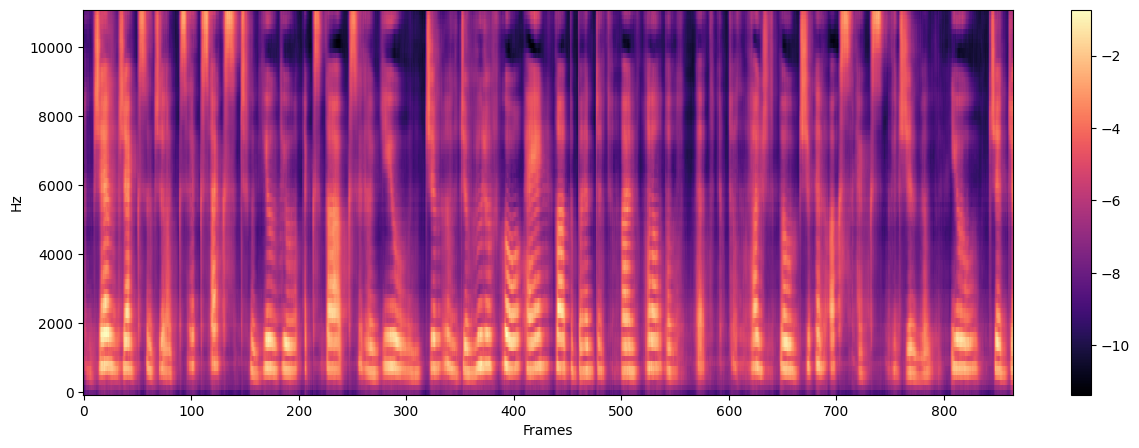

In [264]:
plot_spectrogram(log_mel, batch_index=0)

log_mel[batch_index].transpose(0,1).size()=torch.Size([80, 832])


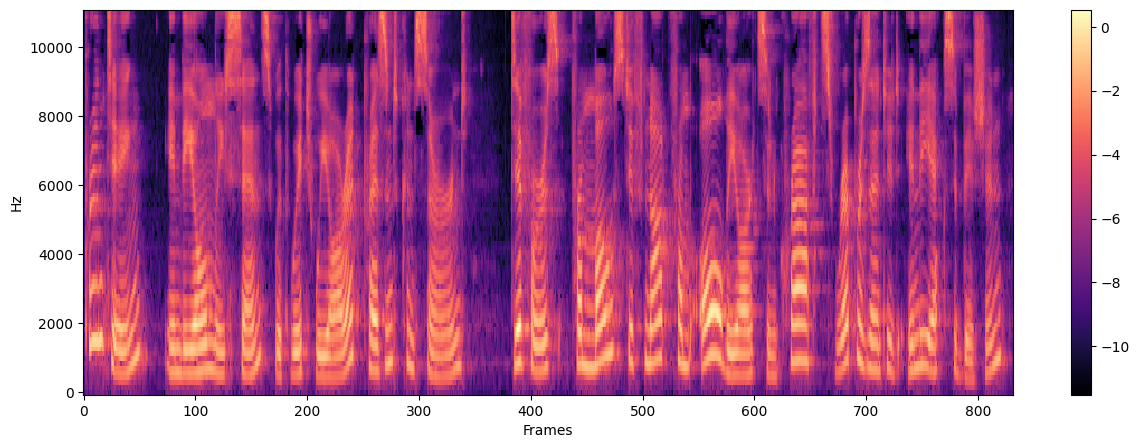

In [265]:
plot_spectrogram(gt_log_mel, batch_index=0)